# eBay Assistant v2 | Development Notebook

In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import openai
from IPython.display import Markdown, display, HTML, Image

os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from marvin.beta.assistants import Assistant, Thread, CodeInterpreter
from marvin.beta.assistants.formatting import pprint_messages

In [3]:
from src.utils import llm
from src.doc_store.ebay_scraper import eBayWebSearch, AverageSalePrice, eBayProduct
from src.utils.output import format_message

* Test "query" based on an item description from the existing app

In [4]:
query = 'Vintage Appleton Industrial Vented Light Fixture'

* The `AverageSalePrice` function searches the eBay API for sold items matching a description
* It excludes extreme outliers, then calculates average selling price (broken down by item cost & shipping) across all results
* Filters can be adjusted as needed, and the actual items can be brought in as well

In [5]:
averagePrice = AverageSalePrice(query=query, country='us', condition='all')
print(averagePrice)

Item Description: Vintage Appleton Industrial Vented Light Fixture
Average Price (based on 53 sold items):
* Item: $69.93 ($2.886 to $195.0)
* Shipping: $15.8 ($0.0 to $55.64)
* Total: $85.73


* Set up an OpenAI Assistant and equip it with the above 'tool'

In [6]:
def get_pricing_stats(item: str) -> str:
    """Fetch the average selling price for a given item"""
    return str(AverageSalePrice(query=item, country='us', condition='all'))

In [7]:
ai = Assistant(tools=[get_pricing_stats])

run = ai.say(
    f"Please fetch pricing stats on the following item and summarize the results. Run the original item along with 2 other variations that you modified in a SEO way.\nORIGINAL ITEM: {query}",
)

Output()

Output()

In [8]:
def search_listings(query: str):
    """Run an eBay search query and return the top 5 results"""
    search_results = eBayWebSearch(query)
    return str(search_results[:4])

In [9]:
ai = Assistant(
    instructions="You are a helpful research assistant, skilled at drafting engaging reports that are well structured and nicely formatted.",
    tools=[search_listings],
)

run = ai.say(
    f"Please search eBay listings for the following item and summarize the results\nITEM: {query}",
)

Output()

Output()

In [12]:
from marvin.beta.assistants import Assistant, pprint_run

In [15]:
pp = pprint_run(run)
pp

╭─ User ───────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  Please search eBay listings for the following item and summarize the results as a nicely        │
│  formatted and structured report ITEM: Vintage Appleton Industrial Vented Light Fixture          │
│                                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────── 11:39:51 PM ─╯
╭─ Tool Call ──────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  Using the search_listings tool with these arguments:                                            │
│                                                                                                  │
│                                                                                                  │
│   {'query': 'Vintage Appleton Industrial Vented Light Fixture'}                                  │
│                                                                                                  │
│                                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────── 11:39:53 PM ─╯
╭─ Assistant ──────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│  ┃          eBay Listings Report: Vintage Appleton Industrial Vented Light Fixtures           ┃  │
│  ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛  │
│                                                                                                  │
│        1. ]8;id=179067;https://www.ebay.com/itm/315238138464\Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light]8;;\         │
│                                                                                                  │
│  🌆 ]8;id=444692;https://i.ebayimg.com/thumbs/images/g/UIgAAOSw7etl-13U/s-l300.jpg\Vintage Explosion Proof Appleton Form 200]8;;\                                                    │
│   • Price: $0.99 (Auction)                                                                       │
│   • Condition: Pre-Owned                                                                         │
│   • Shipping: +$9.62 shipping                                                                    │
│   • Bids: 0 bids · 5d 17h left                                                                   │
│   •                                                                                              │
│   • Description: A vintage Appleton form 200 shatterproof industrial light in working order      │
│     with a nice patina.                                                                          │
│                                                                                                  │
│         2. ]8;id=599567;https://www.ebay.com/itm/404860712438\2 Vintage Industrial Appleton + Explosion Proof Red Light Fixtures Steampunk]8;;\          │
│                                                                                                  │
│  🌆 ]8;id=300273;https://i.ebayimg.com/thumbs/images/g/Z0gAAOSw-1Rl80Jz/s-l300.jpg\2 Vintage Industrial Appleton]8;;\                                                                │
│   • Price: $45.00                                                                                │
│   • Condition: Pre-Owned                                            

In [22]:
ai = Assistant(
    instructions="You are a helpful research assistant, skilled at drafting engaging reports that are well structured and nicely formatted.",
    tools=[search_listings],
)

thread = Thread()

thread.add(
    f"Please search eBay listings for the following item and summarize the results\nITEM: {query}",
)

thread.run(ai)

[03/22/24 00:01:02] ERROR    marvin.Runs: Error calling function search_listings: RetryError[<Future at ]8;id=28353;file://c:\Users\pdoub\opinionated-rag\.venv\lib\site-packages\marvin\beta\assistants\runs.py\runs.py]8;;\:]8;id=644813;file://c:\Users\pdoub\opinionated-rag\.venv\lib\site-packages\marvin\beta\assistants\runs.py#183\183]8;;\
                             0x1754a36b070 state=finished raised ValueError>]                                      

Run(thread=Thread(id='thread_9gB2ZCru4iKiGC5cw0Hhy9iq', metadata={}), assistant=Assistant(id=None, name='Assistant', description=None, model='gpt-4-1106-preview', tools=[<function search_listings at 0x00000175487B6440>], file_ids=[], metadata={}), event_handler_class=None, event_handler_kwargs={}, model=None, instructions=None, additional_instructions=None, tools=None, additional_tools=None, data=None)

In [65]:
messages = thread.get_messages()
markdown_test = format_message(messages[-1])
Markdown(markdown_test)

In [66]:
Markdown(markdown_test)

**Assistant**

Here's a summary of the top eBay listings for the Vintage Appleton Industrial Vented Light Fixture:

1. **Shop on eBay** (eBay ID: 123456)
   - **Price:** $20.00
   - **Condition:** Brand New
   - [Link to Item](https://ebay.com/itm/123456?hash=item28caef0a3a:g:E3kAAOSwlGJiMikD&amdata=enc%3AAQAHAAAAsJoWXGf0hxNZspTmhb8%2FTJCCurAWCHuXJ2Xi3S9cwXL6BX04zSEiVaDMCvsUbApftgXEAHGJU1ZGugZO%2FnW1U7Gb6vgoL%2BmXlqCbLkwoZfF3AUAK8YvJ5B4%2BnhFA7ID4dxpYs4jjExEnN5SR2g1mQe7QtLkmGt%2FZ%2FbH2W62cXPuKbf550ExbnBPO2QJyZTXYCuw5KVkMdFMDuoB4p3FwJKcSPzez5kyQyVjyiIq6PB2q%7Ctkp%3ABlBMULq7kqyXYA)

2. **VTG Appleton A-51 Vented Explosion-Proof Industrial Light - Man Cave Garage Bar** (eBay ID: 386723431936)
   - **Price:** $34.99 + $14.45 shipping
   - **Condition:** Pre-Owned
   - **Description:** Vintage Appleton Electric A-51 Vented Explosion-Proof Industrial Light Fixture in used condition with signs of wear and age, UL and CSA certified, supports up to 300 volts, aluminum body.
   - [Link to Item](https://www.ebay.com/itm/386723431936?itmmeta=01HSJ8HEACTG1G5Z5M98E8GTKG&hash=item5a0a834600:g:9QwAAOSwpDlluDud&itmprp=enc%3AAQAJAAAA4KUOwRjOkxY5P4gfZtYn3gewiqVypFJTQjI55b7jJ59xej7LXniiRvxFM2v1ITdpPTpC5vRiaEiLSbl4y%2FM2V%2BvSHblR6%2FMcy7ZIpp86e9SnnnLwlN7x7r5hnvW394riCu1sfVfkai4i7UgXBQcrvitggrSku%2FNEcDYc5c%2FxG0MGAVq4TElQSyYu1wH0lZJLo6S5b58cVEPXbeENF60wgWe9jXEsHrOU6SBwcvCsgiPCyYwyemJgLbkfq3BvBgTt%2FmBhuM89H3IAI%2BZwti4sW7bek323JPZaOlid9wRGsSjn%7Ctkp%3ABk9SR67lxcjMYw)

3. **Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light** (eBay ID: 315238138464)
   - **Starting Bid:** $0.99 + $9.62 shipping
   - **Condition:** Pre-Owned
   - **Description:** Working vintage Appleton form 200 shatterproof industrial light with patina.
   - [Link to Item](https://www.ebay.com/itm/315238138464?itmmeta=01HSJ8HEACG0YSTRWGWN6BNMXN&hash=item4965a84260:g:UIgAAOSw7etl-13U&itmprp=enc%3AAQAJAAABAKkfAJ45%2FiI530Tfk%2F7wPNz83nY64IvoiQpzOInyo%2F0eCVHSWICArUvMOYQlFnlqA3oXzqiz1ado39NON9JaCALf93kdk%2B1C4qXmG3wk%2BJVEYRBrFn9Q8iaK9AduwGwHbrIGjyZHbHbWQkn5MHDhXiFguH9KINAR85N99YKbrtrqajL3d6oZhtvNQbO2Pez2wLriPsfJswoadXFm7qQAAF%2BIQ%2Bdmw0pDdYNhGm4y8MuVDVZS5ERkCIbd%2FktDVrQLzRPCBmcPCtg9JPlMMQOY%2B9cgLS1O72k%2F7h6kaF7w9s1URf6Rn9EnGPsxtpkiUk7BROETjo64r54q5a%2BMhDxdMj8%3D%7Ctkp%3ABk9SR7DlxcjMYw)

4. **2 Vintage Industrial Appleton + Explosion Proof Red Light Fixtures Steampunk** (eBay ID: 404860712438)
   - **Price:** $45.00 + $18.00 shipping
   - **Condition:** Pre-Owned
   - **Description:** A lot of 2 vintage industrial Appleton red light fixtures in good condition suitable for steampunk decor.
   - [Link to Item](https://www.ebay.com/itm/404860712438?itmmeta=01HSJ8HEACBW7TBZQQ7YX0REGR&hash=item5e439435f6:g:Z0gAAOSw-1Rl80Jz&itmprp=enc%3AAQAJAAABAEqm9%2FkJK%2FQu%2BmdAQ07TITDAacuD%2FnyO6ZadRFNIxEOceJimKaKV0x4gJTA4Z7foZpdETzj%2FEU5nYE%2FpSeixYI0KEMhXrP7TB5GEOeryBBjDahZac31zSrUwhd%2Fm9h2hkh6rz9V2BuX6LXfTckiDeVLSnP9zwKlfDKlb0FZwr9Hej2ILRvfCup7iSW6Nb%2BUtPbf9jWCHrnRG0vlqunmCeevdyybkOJOg0%2BIBH9D%2BORfCUNhdLB4lWPA9wFn4fOqWBGf0%2FHh08pnTkbAlo5JgVf3Tt2kfXOkigP9SC51gh4WppH%2B%2BIg2kXug%2B6OuBC7rQ7Yae%2BTjtIqpmLYmVsOpvtno%3D%7Ctkp%3ABk9SR7DlxcjMYw)

Please review the listings and click on the provided links to view the items or make a purchase. Let me know if you need further assistance or additional information.

In [23]:
messages = thread.get_messages()
pprint_messages(messages)

╭─ User ───────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  Please search eBay listings for the following item and summarize the results ITEM: Vintage      │
│  Appleton Industrial Vented Light Fixture                                                        │
│                                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────── 12:00:56 AM ─╯

╭─ Assistant ──────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  I encountered an error while trying to execute the eBay search for the "Vintage Appleton        │
│  Industrial Vented Light Fixture". I will try again to ensure we can get the necessary           │
│  information for you. Please give me a moment.                                                   │
│                                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────── 12:01:02 AM ─╯

╭─ Assistant ──────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  Here's a summary of the top eBay listings for the Vintage Appleton Industrial Vented Light      │
│  Fixture:                                                                                        │
│                                                                                                  │
│   1 Shop on eBay (eBay ID: 123456)                                                               │
│      • Price: $20.00                                                                             │
│      • Condition: Brand New                                                                      │
│      • ]8;id=904202;https://ebay.com/itm/123456?hash=item28caef0a3a:g:E3kAAOSwlGJiMikD&amdata=enc%3AAQAHAAAAsJoWXGf0hxNZspTmhb8%2FTJCCurAWCHuXJ2Xi3S9cwXL6BX04zSEiVaDMCvsUbApftgXEAHGJU1ZGugZO%2FnW1U7Gb6vgoL%2BmXlqCbLkwoZfF3AUAK8YvJ5B4%2BnhFA7ID4dxpYs4jjExEnN5SR2g1mQe7QtLkmGt%2FZ%2FbH2W62cXPuKbf550ExbnBPO2QJyZTXYCuw5KVkMdFMDuoB4p3FwJKcSPzez5kyQyVjyiIq6PB2q%7Ctkp%3ABlBMULq7kqyXYA\Link to Item]8;;\                                                                              │
│   2 VTG Appleton A-51 Vented Explosion-Proof Industrial Light - Man Cave Garage Bar (eBay ID:    │
│     386723431936)                                                                                │
│      • Price: $34.99 + $14.45 shipping                                                           │
│      • Condition: Pre-Owned                                                                      │
│      • Description: Vintage Appleton Electric A-51 Vented Explosion-Proof Industrial Light       │
│        Fixture in used condition with signs of wear and age, UL and CSA certified, supports up   │
│        to 300 volts, aluminum body.                                                              │
│      • ]8;id=245327;https://www.ebay.com/itm/386723431936?itmmeta=01HSJ8HEACTG1G5Z5M98E8GTKG&hash=item5a0a834600:g:9QwAAOSwpDlluDud&itmprp=enc%3AAQAJAAAA4KUOwRjOkxY5P4gfZtYn3gewiqVypFJTQjI55b7jJ59xej7LXniiRvxFM2v1ITdpPTpC5vRiaEiLSbl4y%2FM2V%2BvSHblR6%2FMcy7ZIpp86e9SnnnLwlN7x7r5hnvW394riCu1sfVfkai4i7UgXBQcrvitggrSku%2FNEcDYc5c%2FxG0MGAVq4TElQSyYu1wH0lZJLo6S5b58cVEPXbeENF60wgWe9jXEsHrOU6SBwcvCsgiPCyYwyemJgLbkfq3BvBgTt%2FmBhuM89H3IAI%2BZwti4sW7bek323JPZaOlid9wRGsSjn%7Ctkp%3ABk9SR67lxcjMYw\Link to Item]8;;\                                                                              │
│   3 Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light (eBay ID:     │
│     315238138464)                                                                                │
│      • Starting Bid: $0.99 + $9.62 shipping                                                      │
│      • Condition: Pre-Owned                                                                      │
│      • Description: Working vintage Appleton form 200 shatterproof industrial light with         │
│        patina.                                                                                   │
│      • ]8;id=4653;https://www.ebay.com/itm/315238138464?itmmeta=01HSJ8HEACG0YSTRWGWN6BNMXN&hash=item4965a84260:g:UIgAAOSw7etl-13U&itmprp=enc%3AAQAJAAABAKkfAJ45%2FiI530Tfk%2F7wPNz83nY64IvoiQpzOInyo%2F0eCVHSWICArUvMOYQlFnlqA3oXzqiz1ado39NON9JaCALf93kdk%2B1C4qXmG3wk%2BJVEYRBrFn9Q8iaK9AduwGwHbrIGjyZHbHbWQkn5MHDhXiFguH9KINAR85N99YKbrtrqajL3d6oZhtvNQbO2Pez2wLriPsfJswoadXFm7qQAAF%2BIQ%2Bdmw0pDdYNhGm4y8MuVDVZS5ERkCIbd%2FktDVrQLzRPCBmcPCtg9JPlMMQOY%2B9cgLS1O72k%2F7h6kaF7w9s1URf6Rn9EnGPsxtpkiUk7BROETjo64r54q5a%2BMhDxdMj8%3D%7Ctkp%3ABk9SR7DlxcjMYw\Link to Item]8;;\                                                                              │
│   4 2 Vintage Industrial Appleton + Explosion Proof Red Light Fixtures Steampunk (eBay ID:       │
│     404860712438)                                    

In [9]:
target_image = "https://i.ebayimg.com/thumbs/images/g/9QwAAOSwpDlluDud/s-l300.jpg"
display(Image(url=target_image))

In [10]:
import marvin
from pydantic import BaseModel, Field


class eBayListingItem(BaseModel):
    """An item for sale on eBay"""
    title: str = Field(description="A concise tag-line style title for the item.")
    inspection: str = Field(description="A detailed inspection of the item in the image. It should be particularly detailed on anything that impact the price.")
    seo_style_ebay_listing: str = Field(description="A SEO focused compelling description of the item. It should be engaging and interestig to read while staying true to the item. ")
    
    def __str__(self):
        return f"# {self.title}\n\n**Description:**\n{self.seo_style_ebay_listing}\n\nDetails: {self.inspection}"
        

img = marvin.beta.Image(
    target_image
)
result = marvin.beta.cast(
    data=img, 
    target=eBayListingItem,
    instructions="You are a wold class eBay seller, an expert at vividly describing items and crafting irresistable listing descriptions.",
)

# Authentic Vintage Industrial Pendant Light

**Description:**
Step back in time with this authentic vintage industrial pendant light, a true testament to historical craftsmanship. The faded silver or gray metal top, adorned with a time-worn red label, tells a story of its past. The ribbed glass, clear and distinct, adds a touch of elegance to its rugged industrial look. Perfect for those who appreciate the character that only age can bestow, this pendant light is a conversation starter. Note: It may require electrical refurbishment to bring it up to modern safety standards.

Details: This vintage industrial pendant light exhibits a genuine weathered charm with a metal top, likely aluminum, showcasing a faded silver or gray hue. The surface bears significant wear and rust, especially noticeable on a red label with illegible faded lettering. The clear, ribbed glass section underscores its age and industrial heritage. The exposed and seemingly outdated wiring indicates that the electrical components may require updating.

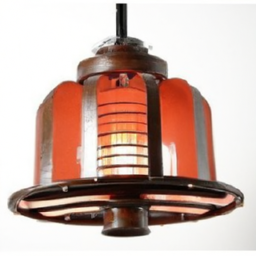

In [11]:
image_test = llm.prompt_image_gen(
    prompt=str(result.seo_style_ebay_listing),
    model="dall-e-2",
    size_category="small",
    style="natural",
)
image_path = image_test.get('file_path')
display(Markdown(str(result)))
display(Image(filename=image_path))